In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm
%matplotlib inline

csvs = [] 

for i in range(1,4):
    csvs.append('search' + str(i) + '.csv')

df = pd.DataFrame()
cols_to_drop = ['internal_node_id', 'trial_index', 'time_elapsed', 
                'view_history', 'trial_type', 'response', 'stimulus', 'task']

for index, path in enumerate(csvs):
    df_ = pd.read_csv(path)
    df_ = df_[df_['trial_type'] == 'canvas-keyboard-response']
    df_.drop(cols_to_drop, axis=1, inplace=True)
    print('Accuracy for participant', index, ':', sum(df_['correct']/len(df_)), 'Avg RT:', sum(df_['rt']) / len(df_))
    df_ = df_[df_['correct'] == True]
    df_.drop('correct', axis=1, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    df_['participant_id'] = index
    df = df.append(df_)

df.reset_index(drop=True, inplace=True)
df['rt'] = df['rt'].astype('uint32')
df['setSize'] = df['setSize'].astype('uint32')
df = df.rename(columns=({'conjuction' : 'conjunction'}))
df['present'] = df['present'].astype('bool')
df['absent'] = ~df['present']
df['conjunction'] = df['conjunction'].astype('bool')
df['feature'] = ~df['conjunction']
df['intercept'] = np.ones(df['rt'].shape)
df.replace({True : 1, False : 0}, inplace=True)
print()

# regression model predicting rt based on set size, search type when the target is present
X = df.loc[(df['present'] == 1) & (df['conjunction'] == 1)].drop(['rt', 'participant_id', 'absent', 'present', 'feature'], axis=1)
y = np.array(df.loc[(df['present'] == 1) & (df['conjunction'] == 1)]['rt'])
alpha = 0.05 

model = sm.OLS(y, X).fit()

conditions = list(itertools.product(['feature', 'conjunction'], ['present', 'absent']))

# individual regression models inspecting each condition combination
for search_type, target_presence in conditions:
    X = df.loc[(df[target_presence] == 1) & (df[search_type] == 1)].drop(['rt', 'participant_id', 'absent', 'present', 'feature', 'conjunction'], axis=1)
    y = np.array(df.loc[(df[target_presence] == 1) & (df[search_type] == 1)]['rt'])
    model = sm.OLS(y, X).fit()
    coeffs = model.params
    conf_int = model.conf_int()
    print(search_type.capitalize() + ' search - target', target_presence, '- all participants')
    print('setSize slope:', round(coeffs[0], 3), 'CI:', round(conf_int[0][0], 3), round(conf_int[1][0], 3))
    print('intercept:', round(coeffs[1], 3), 'CI:', round(conf_int[0][1], 3), round(conf_int[1][1], 3), end='\n\n')
    
# individual regression models for each participant separatelly inspecting each condition combination
for i in range(0,3):
    for search_type, target_presence in conditions:
        X = df.loc[(df[target_presence] == 1) & (df[search_type] == 1) & (df['participant_id'] == i)].drop(['rt', 'participant_id', 'absent', 'present', 'feature', 'conjunction'], axis=1)
        y = np.array(df.loc[(df[target_presence] == 1) & (df[search_type] == 1) & (df['participant_id'] == i)]['rt'])
        model = sm.OLS(y, X).fit()
        coeffs = model.params
        conf_int = model.conf_int()
        print(search_type.capitalize() + ' search - target', target_presence, '- participant' + str(i))
        print('setSize slope:', round(coeffs[0], 3), 'CI:', round(conf_int[0][0], 3), round(conf_int[1][0], 3))
        print('intercept:', round(coeffs[1], 3), 'CI:', round(conf_int[0][1], 3), round(conf_int[1][1], 3), end='\n\n')

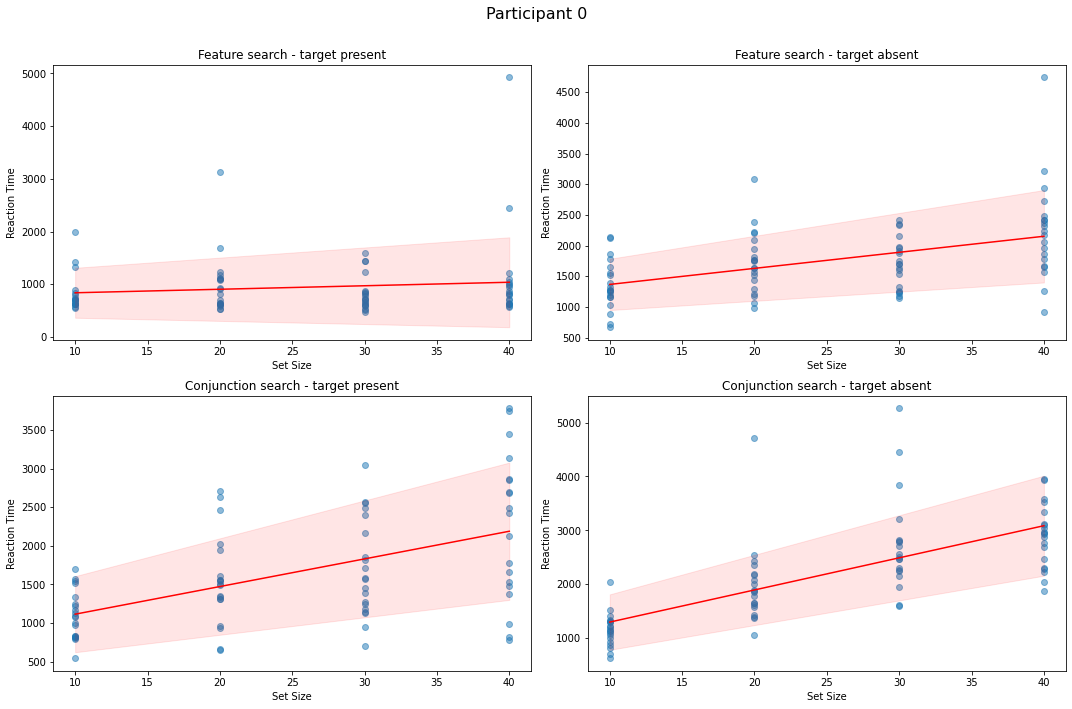

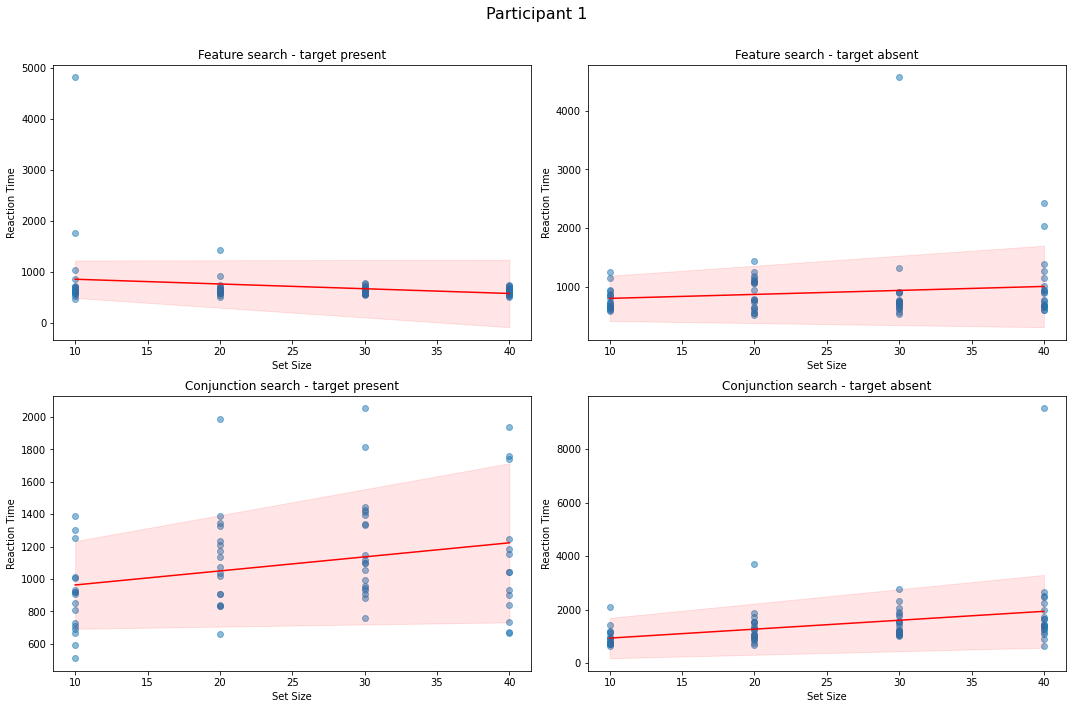

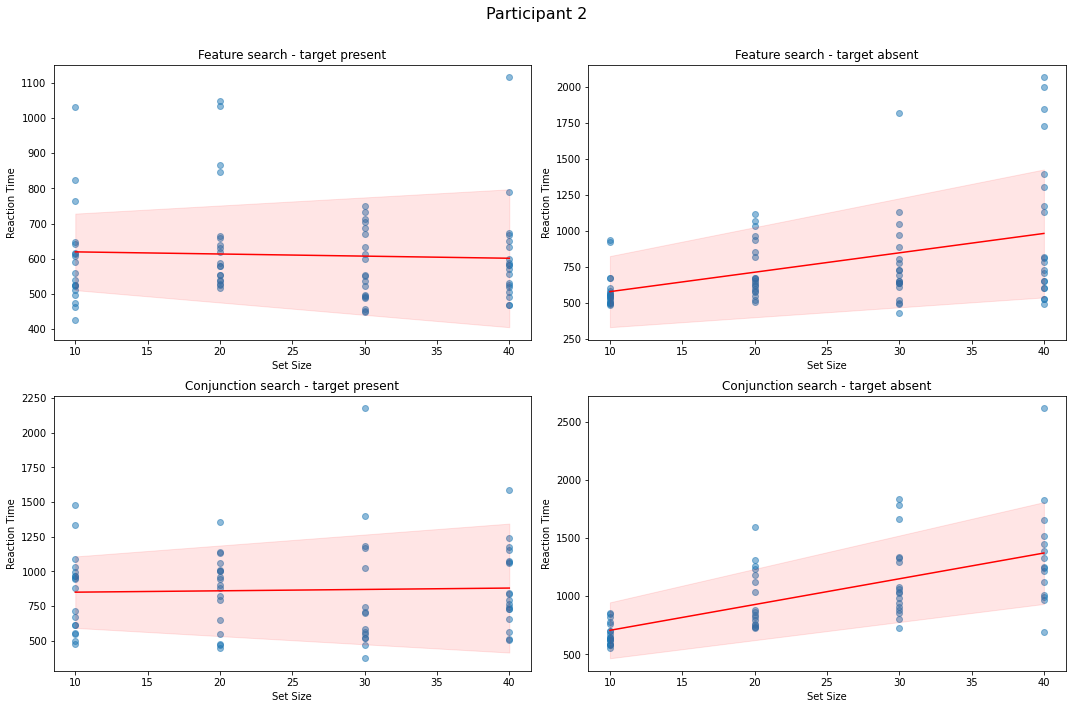

In [18]:
def plot_regression(df, participant_id):
    conditions = list(itertools.product(['feature', 'conjunction'], ['present', 'absent']))
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Participant {participant_id}', fontsize=16)

    for i, (search_type, target_presence) in enumerate(conditions):
        ax = axs[i//2, i%2]
        data = df.loc[(df[target_presence] == 1) & (df[search_type] == 1) & (df['participant_id'] == participant_id)]
        X = data['setSize']
        y = data['rt']
        
        model = sm.OLS(y, sm.add_constant(X)).fit()
        coeffs = model.params
        conf_int = model.conf_int()
        
        # generate the x values for the regression line
        x_reg = np.linspace(X.min(), X.max(), 100)
        
        # calculate the y values for the regression line
        y_reg = coeffs[0] + coeffs[1] * x_reg
        
        # calculate the y values for the upper and lower bounds of the confidence interval
        y_ci_lower = conf_int[0][0] + conf_int[0][1] * x_reg
        y_ci_upper = conf_int[1][0] + conf_int[1][1] * x_reg
        
        # plot the data points
        ax.scatter(X, y, alpha=0.5)
        
        # plot the regression line
        ax.plot(x_reg, y_reg, color='red')
        
        # plot the confidence interval
        ax.fill_between(x_reg, y_ci_lower, y_ci_upper, color='red', alpha=0.1)
        
        ax.set_title(f'{search_type.capitalize()} search - target {target_presence}')
        ax.set_xlabel('Set Size')
        ax.set_ylabel('Reaction Time')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

for i in range(3):
    plot_regression(df, i)